In [1]:
# cleaned up manipulation of bio-mart exports
# across multiple chromosomes

# stephani needed more samples. this is all chromosomes


In [19]:
import pandas as pd
from Bio.Seq import Seq # for rev-comp
from glob import glob
import re
import numpy as np

import tempfile
import subprocess
from tqdm import tqdm

In [2]:

def load_ref_chromosome(chrome_index: int,
                        folder:str):
    # get the path
    ref_chrome_path = _get_ref_chromosome_path(chrome_index, folder)
    # load the chrome
    with open(ref_chrome_path,'r') as f:
        ref_chrome = f.readlines()
    # cleanup (drop name, just NTs)
    ref_chrome = ''.join(ref_chrome[1:]).replace('\n','')
    return ref_chrome
    
def _get_ref_chromosome_path(chrome_index:int,
                             folder:str):
    ref_chrome_path = glob(f'{folder}*.{chrome_index}.fa')[0]
    return ref_chrome_path

In [3]:
def rev_comp(seq:str) -> str:
    return Seq(seq).reverse_complement().__str__()

In [4]:

def remove_non_protein(df) -> pd.DataFrame:
    df['Protein stable ID'] = df['Protein stable ID'].astype(str)
    return df[df['Protein stable ID'] != 'nan']

def strand_plus_minus(df) -> pd.DataFrame:
    df['Strand'] = df['Strand'].replace(1,'+')
    df['Strand'] = df['Strand'].replace(-1,'-')
    return df

def save_as_bed(df, bed_path):
    ''' user must ensure correctness '''
    # save
    df.to_csv(bed_path,
             header=None,
             index=None,
             sep='\t')

def load_bed(bed_path):
    # load bed
    z = pd.read_csv(bed_path,
                    delimiter='\t',
                    header=None)
    # rename columns for convenience
    z = z.rename(columns = dict(zip(np.arange(6),
                           ['chr','start','end','name','score','strand'])))
    return z

def save_fasta(save_path:str,
               list_of_fastas: list[str]) -> None:
    with open(save_path, 'w') as f:
        for _line in list_of_fastas:
            f.write(_line.replace('\n','')+'\n')

def _getfasta(bed_path, genome_path):
    # run the command
    z = subprocess.run(args = ['./bedtools',
                               'getfasta',
                               '-s',
                               '-fi',
                               genome_path,
                               '-bed',
                               bed_path],
                       cwd='/Users/Finn/bedtools/bin',
                       capture_output=True
                      )
    # cleanup output into a fasta file
    z = z.stdout.decode()
    return z

def _addslop(bed_path, genome_path,flank=10):
    # load bed
    temp_bed = load_bed(bed_path)
    temp_bed['start'] -= flank
    temp_bed['end'] += flank
    with tempfile.NamedTemporaryFile() as f:
        save_as_bed(temp_bed, bed_path = f.name)#
        f.flush() # push the data "in" the file from buffer to disk
        z = _getfasta(f.name, genome_path)

    return z

def save_fasta(save_path:str,
               list_of_fastas: list[str]) -> None:
    with open(save_path, 'w') as f:
        for _line in list_of_fastas:
            f.write(_line.replace('\n','')+'\n')
            
def export_to_bed(chrome, start, end, name, score, strand):
    save_df = pd.DataFrame()
    if isinstance(chrome, int):
        save_df['chrome'] = np.ones(len(start),dtype=int)*chrome
    else:
        save_df['chrome'] = chrome
    save_df['start'] = start # junction positions
    save_df['end'] = end # junction positions +1
    save_df['name'] = ['filler'] * len(start) #name.values # this doesn't transfer into "getfasta"
    save_df['score'] = np.zeros(len(start)) # dumby scores
    save_df['strand'] = strand
    return save_df

def load_mart(file_path: str) -> pd.DataFrame:
    mart_export = pd.read_csv(file_path)
    return mart_export

In [5]:
def get_junctions(mart_path:str, chrome_index:int,
                  save_path:str
                 ):
    # load raw biomart file
    temp_mart = load_mart(mart_path)
    temp_mart = strand_plus_minus(temp_mart)
    # build up bed files in dataframe
    donors_start = list()
    donors_end = list()
    acceptors_start = list()
    acceptors_end = list()
    strand = list()

    unique_genes = np.unique(temp_mart['Transcript stable ID version'])
    # this isn't the right way to do this, should be a .groupby?
    for _gene in unique_genes:
        mask = (temp_mart['Transcript stable ID version'] == _gene)
        temp_df = temp_mart[mask]
        
        if temp_df['Strand'].iloc[0] == '-':
            # sort for safety
            temp_df = temp_df.sort_values('Exon region start (bp)',ascending=False)
            # add junctions
            for i in temp_df['Exon region end (bp)'][1:]:
                strand.append('-')
                acceptors_start.append(i)
                acceptors_end.append(i+1)
            for i in temp_df['Exon region start (bp)'][:-1]:
                donors_start.append(i-2)
                donors_end.append(i-1)

        else:
            # sort for safety
            temp_df = temp_df.sort_values('Exon region start (bp)')
            # add junctions
            for i in temp_df['Exon region end (bp)'][:-1]:
                strand.append('+')
                donors_start.append(i)
                donors_end.append(i+1)
            for i in temp_df['Exon region start (bp)'][1:]:
                acceptors_start.append(i-2)
                acceptors_end.append(i-1)
            
    # create bed table
    junction_donor_bed = export_to_bed(chrome = chrome_index,
                                       start = donors_start,
                                       end = donors_end,
                                       name = 'dumby_arg',
                                       score = 'dumby_arg',
                                       strand = strand)
    save_as_bed(junction_donor_bed,
                bed_path=f'{save_path}_donor.bed')
    
    junction_acceptor_bed = export_to_bed(chrome = chrome_index,
                                       start = acceptors_start,
                                       end = acceptors_end,
                                       name = 'dumby_arg',
                                       score = 'dumby_arg',
                                       strand = strand)
    save_as_bed(junction_acceptor_bed,
                bed_path=f'{save_path}_acceptor.bed')
    


### split biomart output by chromosome

In [ ]:
# split by chromosome
# minimizing opening and closing of human chromosomes (and not requiring them to all be open at once)

mart_path = '/Users/Finn/desktop/splicing_files/martquery_1119000515_815_all_chromes.txt'

# cleanup
temp_mart = load_mart(mart_path)
temp_mart = strand_plus_minus(temp_mart)

# split by chromosome number
source = 'martquery_1119000515_815' # this helps keep track of the lineage of this data
chromes = np.unique(temp_mart['Chromosome/scaffold name'])

for _chrome in chromes:    
    temp_mart[temp_mart['Chromosome/scaffold name'] == _chrome].to_csv(f'{raw_mart_folder}{source}_chr{_chrome}.txt',index=None)

#### loop over chromosomes

In [21]:
raw_mart_folder = '/Users/Finn/desktop/splicing_files/mart_exports/'
junction_folder = '/Users/Finn/desktop/splicing_files/junctions/'
ref_genome_folder = '/Users/Finn/desktop/splicing_files/reference_chromes/'
fasta_folder = '/Users/Finn/desktop/splicing_files/junction_fastas/'


In [24]:
flank_size = 100

for _file in glob(f'{raw_mart_folder}*'):
    # extract chrome index
    _chrome = int(_file.split('/')[-1].split('chr')[1].split('.')[0])
    print('working on:',_chrome)
    
    # extract junctions into bed files
    get_junctions(mart_path = _file,
                  chrome_index = _chrome,
                  save_path = f'{junction_folder}chr{_chrome}')
    
    # extract acceptors
    ref_chrome_path = glob(f'{ref_genome_folder}*.{_chrome}.fa')[0]
    flanked = _addslop(f'{junction_folder}chr{_chrome}_acceptor.bed',
                       ref_chrome_path, flank=flank_size).split('\n')
    save_fasta(f'{fasta_folder}chr{_chrome}_acceptor.fa', list_of_fastas=flanked)
    
    # extract donors
    ref_chrome_path = glob(f'{ref_genome_folder}*.{_chrome}.fa')[0]
    flanked = _addslop(f'{junction_folder}chr{_chrome}_donor.bed',
                       ref_chrome_path, flank=flank_size).split('\n')
    save_fasta(f'{fasta_folder}chr{_chrome}_donor.fa', list_of_fastas=flanked)


working on: 4
working on: 5
working on: 7
working on: 6
working on: 2
working on: 3
working on: 1
working on: 13
working on: 12
working on: 10
working on: 11
working on: 15
working on: 14
working on: 16
working on: 17
working on: 19
working on: 18
working on: 20
working on: 21
working on: 22
working on: 8
working on: 9


In [89]:
mart_path = '/Users/Finn/desktop/splicing_files/mart_exports/martquery_1108044906_870_chr19.txt'
ref_genome_folder = '/Users/Finn/desktop/splicing_files/reference_chromes/'

d19_bed = collect_negative_junctions(mart_path = mart_path,
                            chrome_index = 19,
                            ref_genome_folder = ref_genome_folder,
                            junction_type = 'D')


In [90]:
save_as_bed(d19_bed,
            bed_path = '/Users/Finn/desktop/d19_contol.bed')


In [91]:
control_fasta = _addslop(bed_path = '/Users/Finn/desktop/d19_contol.bed',
         genome_path=_get_ref_chromosome_path(chrome_index=19,
                                              folder=ref_genome_folder),
         flank=2).split('\n')

control_fasta[:10] # looks good

['>19:46022941-46022946(+)',
 'GGGTC',
 '>19:46019591-46019596(+)',
 'CCGTG',
 '>19:46019183-46019188(+)',
 'CAGTG',
 '>19:1285894-1285899(+)',
 'GGGTG',
 '>19:1295582-1295587(+)',
 'CGGTG']

In [121]:
a19_bed = collect_negative_junctions(mart_path = mart_path,
                            chrome_index = 19,
                            ref_genome_folder = ref_genome_folder,
                            junction_type = 'A')


In [122]:
save_as_bed(a19_bed,
            bed_path = '/Users/Finn/desktop/a19_contol.bed')


In [123]:
control_fasta = _addslop(bed_path = '/Users/Finn/desktop/a19_contol.bed',
         genome_path=_get_ref_chromosome_path(chrome_index=19,
                                              folder=ref_genome_folder),
         flank=2).split('\n')

control_fasta[:20]

['>19:46022985-46022990(+)',
 'GAGAG',
 '>19:46019640-46019645(+)',
 'CAGGA',
 '>19:46019179-46019184(+)',
 'GAGAC',
 '>19:1286305-1286310(+)',
 'CAGGT',
 '>19:1295794-1295799(+)',
 'CAGCT',
 '>19:1298594-1298599(+)',
 'AAGGT',
 '>19:1299837-1299842(+)',
 'GAGGC',
 '>19:49072373-49072378(+)',
 'TAGTA',
 '>19:49070488-49070493(+)',
 'GAGGA',
 '>19:39738010-39738015(+)',
 'GAGCT']

#### seems finalized
how many exons do these single transcripts have?

In [9]:
mart_path = '/Users/Finn/desktop/splicing_files/martquery_1114011419_771_all_chromes.txt'
temp_mart = load_mart(mart_path)
n_exons = list()
unique_genes = np.unique(temp_mart['Transcript stable ID version'])
len(unique_genes)

151009

In [33]:

#mart_path = '/Users/Finn/desktop/splicing_files/mart_exports/martquery_1108044906_870_chr19.txt'
mart_path = '/Users/Finn/desktop/splicing_files/martquery_1113195942_714_all_chromes.txt'
temp_mart = load_mart(mart_path)

n_exons = list()
unique_genes = np.unique(temp_mart['Transcript stable ID version'])
for _gene in unique_genes:
    mask = (temp_mart['Transcript stable ID version'] == _gene)
    temp_df = temp_mart[mask]
    n_exons.append(len(temp_df))
    

In [34]:
len(unique_genes)

41582

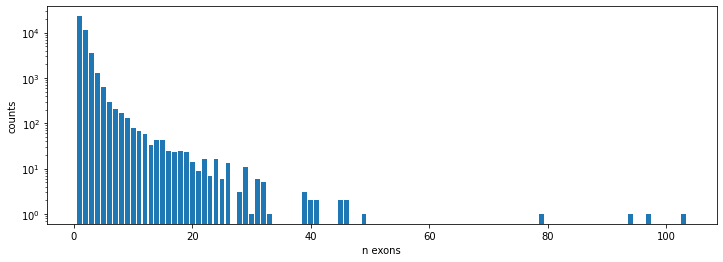

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.bar(*np.unique(n_exons,return_counts=True))
plt.xlabel('n exons');
plt.yscale('log')
plt.ylabel('counts');